In [4]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import h5py
import tables
import tensorflow as tf
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from get_spectrum import get_spectra

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

### Function which creates f_esc vs. halo mass scatter plots with a third halo property used for the color scale

- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account
- **halo_prop**: List of halo-property keys relative to which the relative escape fraction is plotted 
- **x_axis**: Quantity to be plotted on the x-axis. Usually chosen to be the Halo Mass
- **y_axis**: Quantity to be plotted on the y-axis. With the obvious choice being the escape fraction.
- **titles**: List of titles for the individual plots. Should have the same length as halo_prop. By default no titles are used.
- **norms**: Norms for the color scale. Might be usefull if the colorscales are to be kept consistend across differen plots. By default the norms are determined by the range of the given halo property
- **labels**: Labels for the color scales. By default the corresponding halo_prop key is used

In [18]:
def plot_color_coded(dataframe, halo_prop, x_axis='HaloMass', y_axis='f_esc', titles=None, norms=None, labels=None):
    figure, subfigs = plt.subplots(len(halo_prop))
    if labels==None:
        labels=halo_prop
    for i,prop in enumerate(halo_prop):
        color_data = dataframe[prop]
        if norms == None:
            norm = plt.Normalize(color_data.min(), color_data.max())
        else:
            norm = norms[i]

            
        subfig = subfigs[i].scatter(dataframe[x_axis], dataframe[y_axis], c=color_data, s=200, norm=norm)
        subfigs[i].set_xscale('log')
        
        bar = figure.colorbar(subfig, ax=subfigs[i])
        
        subfigs[i].set_ylabel('$f_{esc}$', size='25')
        bar.set_label(labels[i], fontsize=25)
        if i==len(halo_prop)-1:
            subfigs[i].set_xlabel('Halo Mass [$10^{10}M_{\mathrm{sun}}$]', size='25')
        
        if titles!=None:
            subfigs[i].set_title(titles[i],fontsize=30)
            
    plt.show();

### A simple function which returns the intersection of the dust and no_dust run dataframes. Since the halos have to overlap in all properties but the scape fraction all these quantities are automatically overlayed

- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account

In [19]:
def intersect(df_dust, df_no_dust):
    df_intersect = pd.merge(df_dust, df_no_dust, how='inner', on=list(df_dust.keys()[:-1]), suffixes=('_dust', '_no_dust'))
    return df_intersect

### Function which plots the relative diviations of escape fractions between radiation-transfer runs which take dust into account and the ones which do not with respect to different properties of the halos:
- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account
- **halo_prop**: List of halo-property keys relative to which the relative escape fraction is plotted 
- **x_axis_labels**: List of labels for the x-axis, should have the same length as halo_prop. By default halo_prop keys are used.
- **titles**: List of titles for the individual plots. Should have the same length as halo_prop. By default no titles are used. 

In [20]:
def plot_comparisons(df_dust, df_no_dust, halo_prop, x_axis_labels=None, titles=None):
    dataframe = intersect(df_dust, df_no_dust)
    
    if x_axis_labels == None:
        x_axis_labels = halo_prop
    
    figure, subfigs = plt.subplots(len(halo_prop))
    rel_difference = (dataframe['f_esc_no_dust']-dataframe['f_esc_dust'])/dataframe['f_esc_no_dust']
    for i,prop in enumerate(halo_prop):
        data = dataframe[prop]    
            
        subfig = subfigs[i].scatter(dataframe[prop], rel_difference, s=200)
        subfigs[i].set_xscale('log')
        subfigs[i].set_xlim((dataframe[prop].min(),dataframe[prop].max()))
        
        subfigs[i].set_ylabel(r'$\frac{f_{\mathrm{esc}_{\mathrm{no\_dust}}}-f_{\mathrm{esc}_{\mathrm{dust}}}}{f_{\mathrm{esc}_{\mathrm{no\_dust}}}}$', size='25')
        subfigs[i].set_xlabel(x_axis_labels[i], size='25')

        #subfigs[i].legend(fontsize=20)
        
        if titles!=None:
            subfigs[i].set_title(titles[i],fontsize=30)
            
    plt.show();

In [22]:
df_dust = pd.read_hdf('df_f_esc.h5', 'dust')
df_no_dust = pd.read_hdf('df_f_esc.h5', 'no_dust')

In [24]:
import sys

In [26]:
sys.getsizeof(df_no_dust)

24544

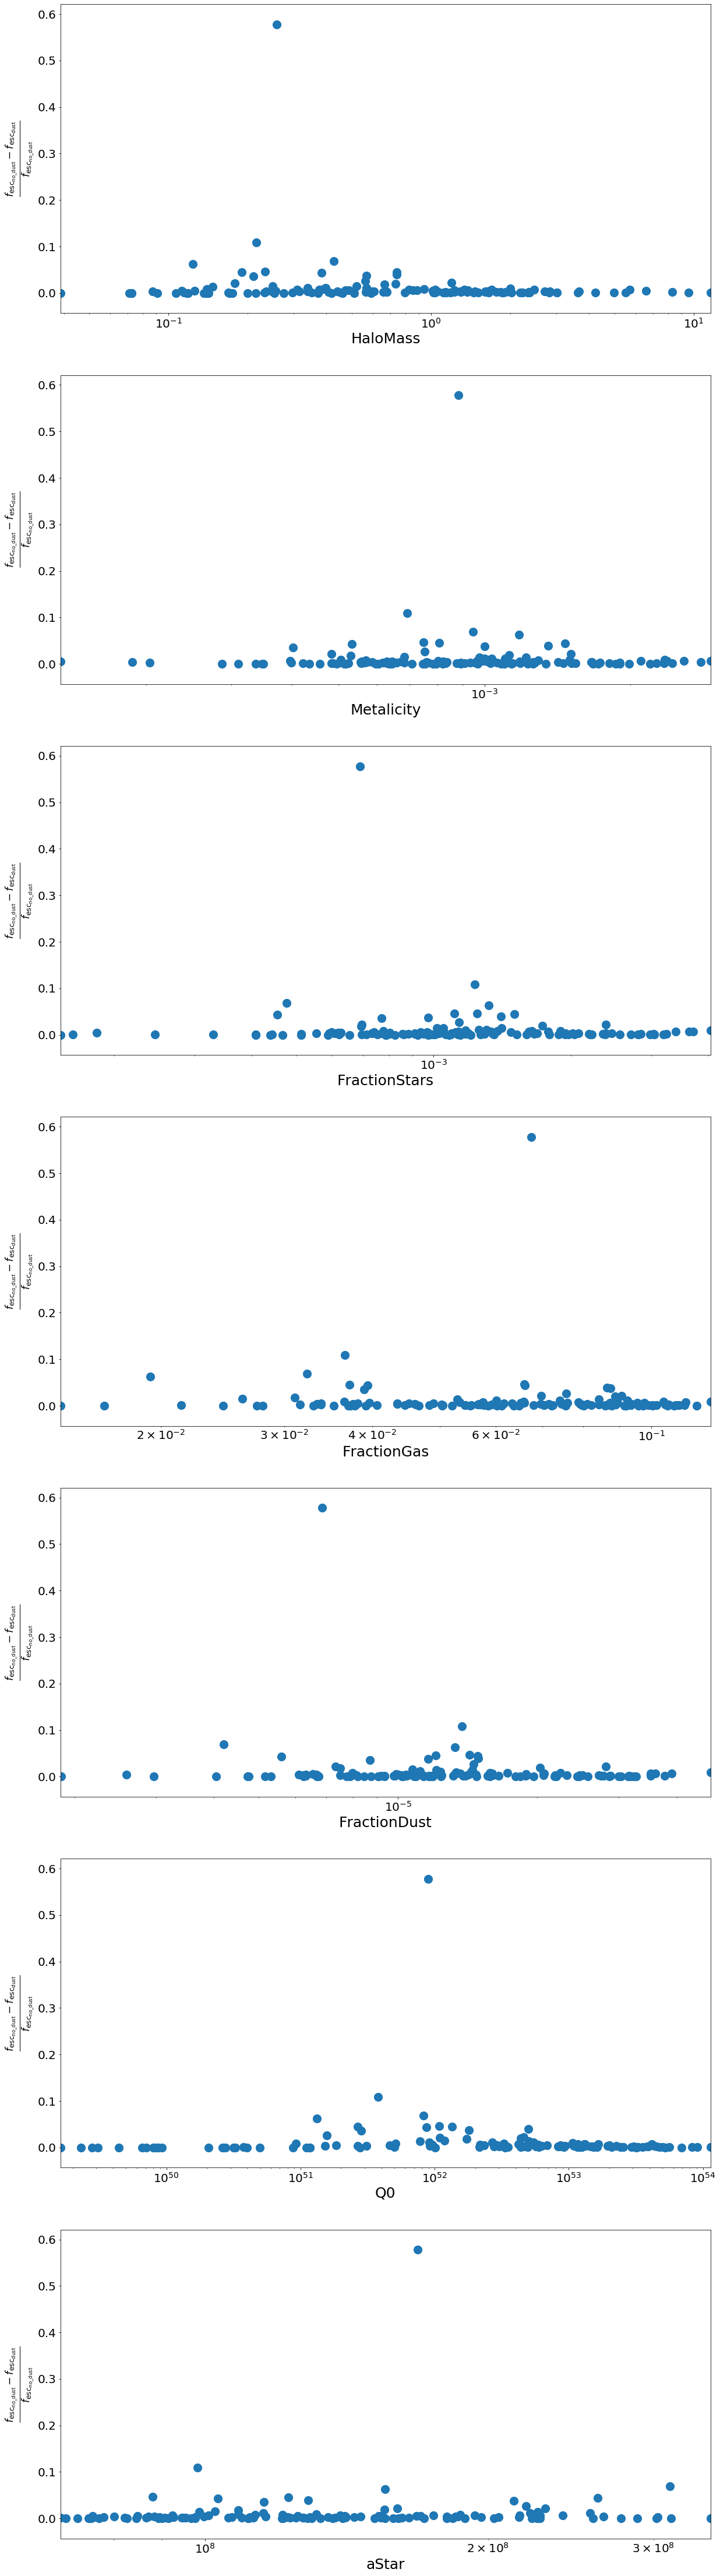

In [10]:
plt.rcParams["figure.figsize"] = (20,80)
plot_comparisons(df_dust, df_no_dust, list(df_dust.keys())[2:-1])

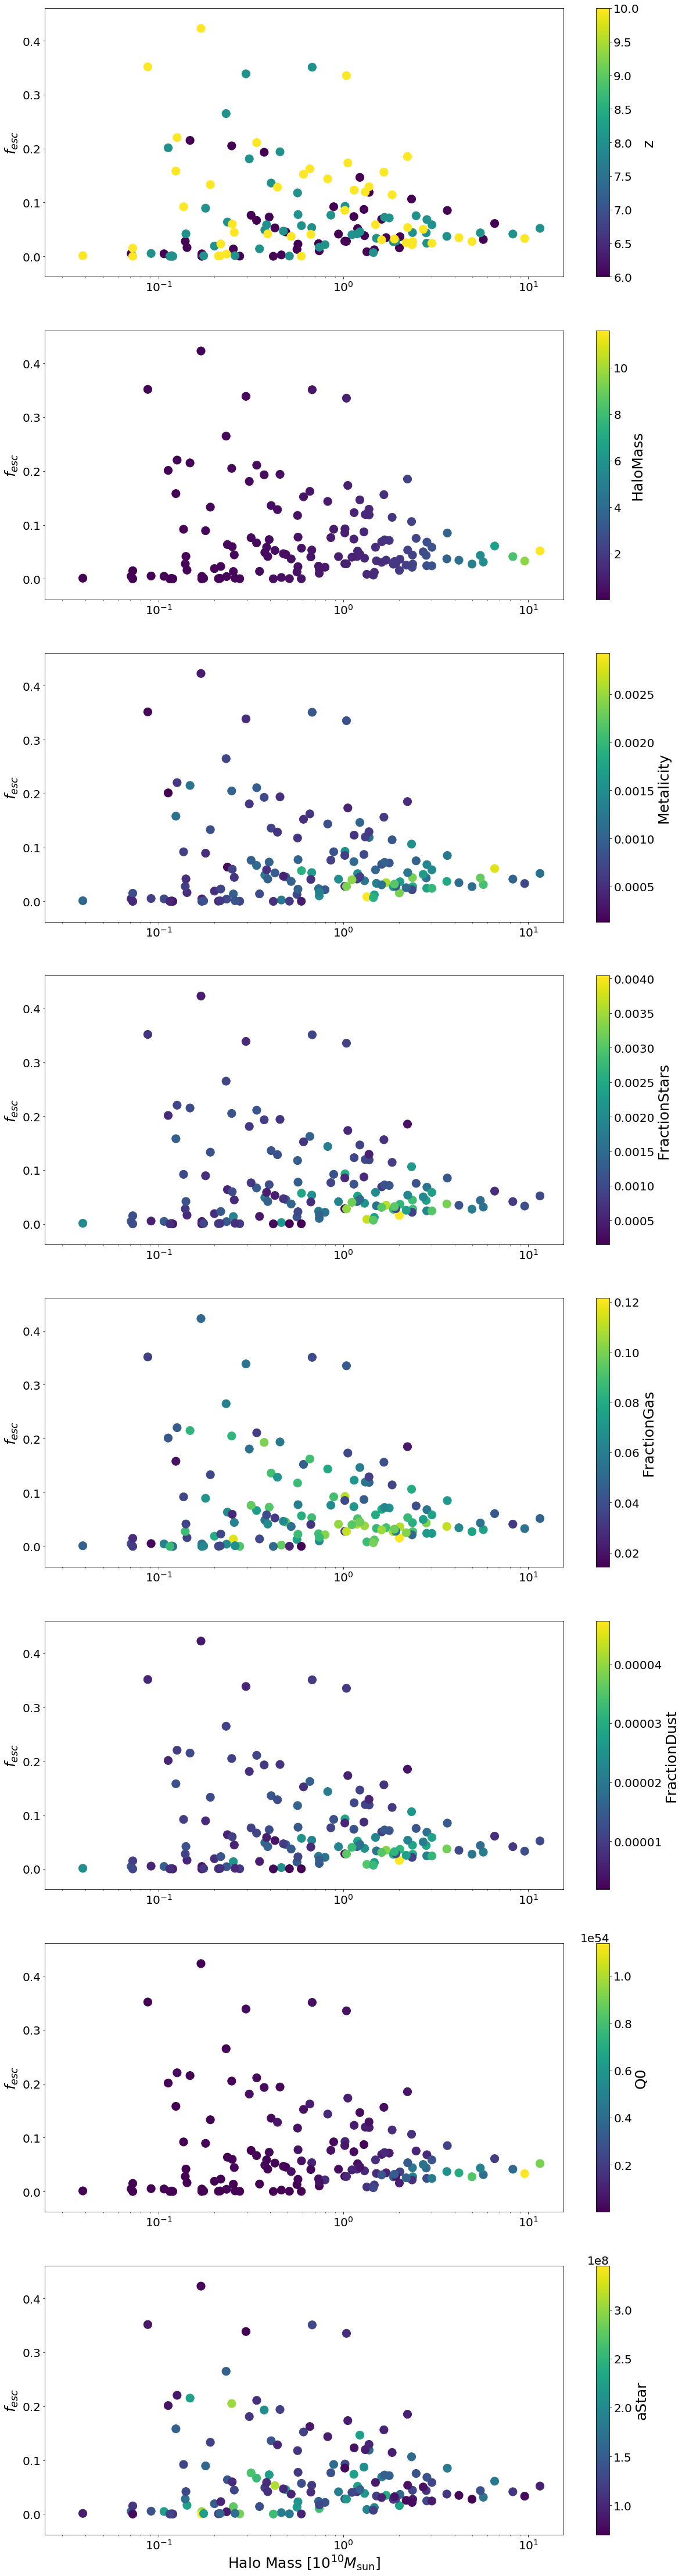

In [17]:
plt.rcParams["figure.figsize"] = (20,80)
plot_color_coded(df_dust, list(df_dust.keys())[1:-1])